In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r "/content/drive/My Drive/Colab Notebooks/Trajectron++/requirements.txt"

In [56]:
%cd /content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/nuScenes

/content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/nuScenes


## Run this to create the .pkl for deriving scenes

In [4]:
# !python process_data.py --data=./v1.0-mini --version="v1.0-mini" --output_path=../processed
!python process_data.py --data=v1.0 --version="v1.0-trainval" --output_path=../processed

Traceback (most recent call last):
  File "process_data.py", line 18, in <module>
    from environment import Environment, Scene, Node, GeometricMap, derivative_of
  File "../../trajectron/environment/__init__.py", line 1, in <module>
    from .data_structures import RingBuffer, SingleHeaderNumpyArray, DoubleHeaderNumpyArray
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 764, in get_code
  File "<frozen importlib._bootstrap_external>", line 833, in get_data
KeyboardInterrupt


In [3]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization

## Load nuScenes SDK and data

In [4]:
nuScenes_data_path = './v1.0'
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [5]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

# Map Encoding Demo

In [45]:
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [7]:
ph = 6
log_dir = './models'

In [8]:
model_dir = os.path.join(log_dir, 'int_ee_me') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



In [49]:
scene = eval_scenes[20]
print("scene name: " + scene.name)
print("timesteps : " + str(scene.timesteps))
print("x_min     : " + str(scene.x_min))
print("y_min     : " + str(scene.y_min))
# scene.nodes[1].data.data

scene name: 100
timesteps : 39
x_min     : 472.0
y_min     : 1436.0


In [50]:
# Define ROI in nuScenes Map
# x_min = 773.0
# x_max = 1100.0
# y_min = 1231.0
# y_max = 1510.0

x_min = 472.0
x_max = 772.0
y_min = 1436.0
y_max = 1736.0

In [38]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

## Prediction including Map Encoding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


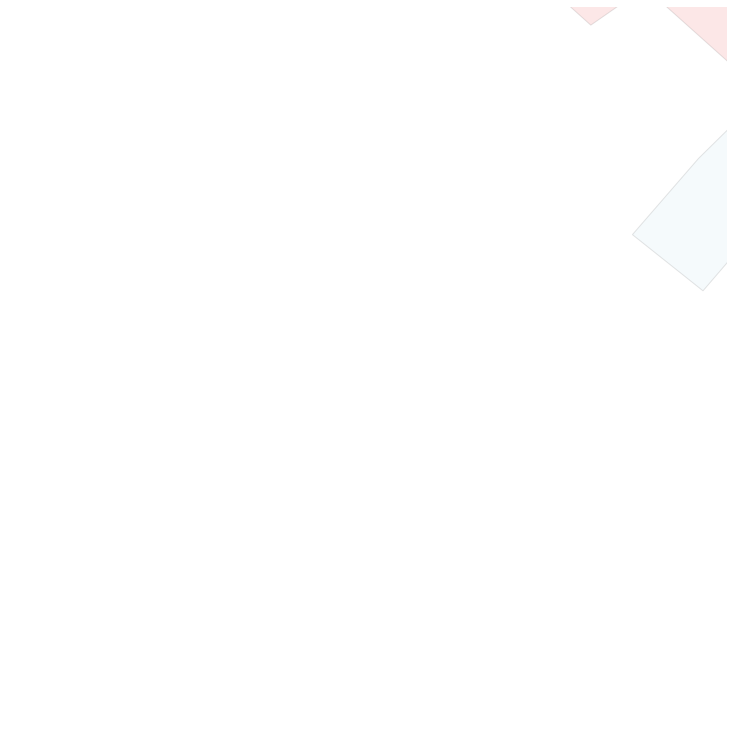

In [55]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    # ax.set_ylim((1385, 1435))
    # ax.set_xlim((850, 900))
    ax.set_ylim((1550, 1600))
    ax.set_xlim((600, 650))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_pos.pdf', dpi=300, bbox_inches='tight')

## Prediction without Map Encoding

In [ ]:
model_dir = os.path.join(log_dir, 'int_ee') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/int_ee/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


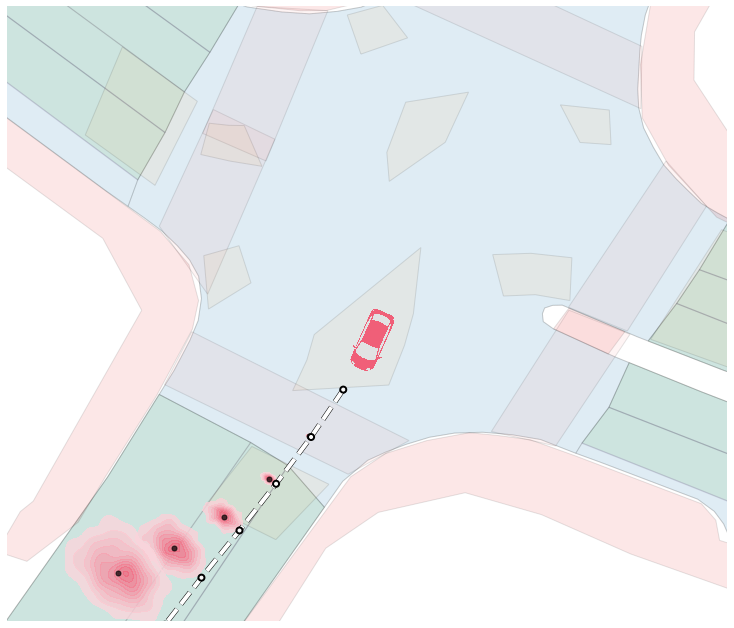

In [ ]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_nm.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_pos.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output

In [ ]:
model_dir = os.path.join(log_dir, 'vel_ee') 
eval_stg_vel, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/vel_ee/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


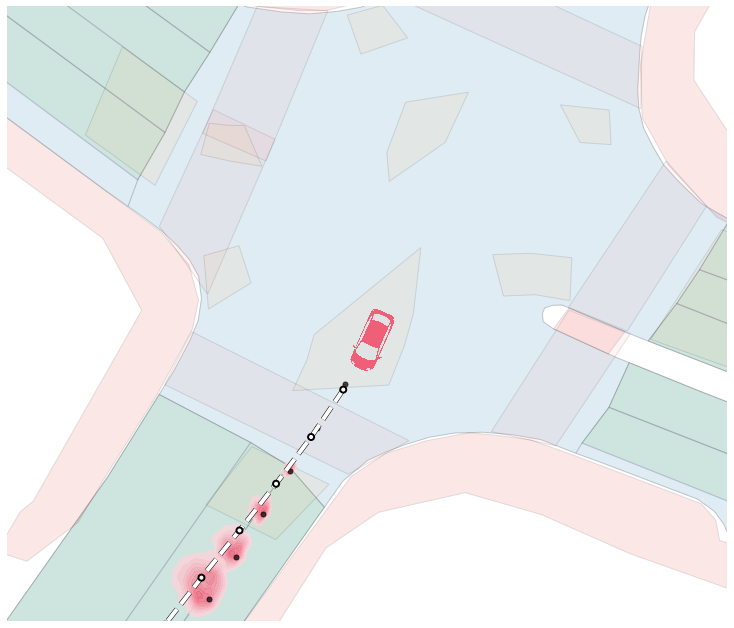

In [ ]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_vel.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output and map

In [ ]:
model_dir = os.path.join(log_dir, 'vel_ee') 
eval_stg_vel_map, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/vel_ee/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


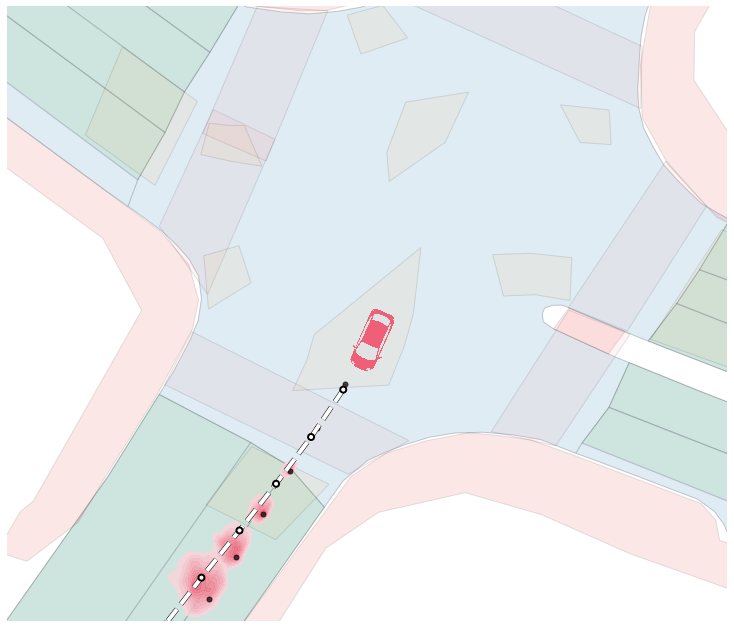

In [ ]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel_map.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel_map.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_vel.pdf', dpi=300, bbox_inches='tight')

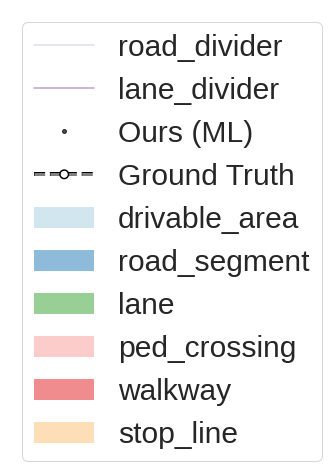

In [ ]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')